# Loading Images

In [59]:
import numpy as np
from glob import glob

print('loading...')
# load filenames for human and dog images
original_images = np.array(glob("images/wang-train/*"))

# print number of images in each dataset
print('There are %d total original images.' % len(original_images))

loading...
There are 144 total original images.


# Face Detection and extract cropped image with 90 % of face using OpenCV

Number of faces detected: 3


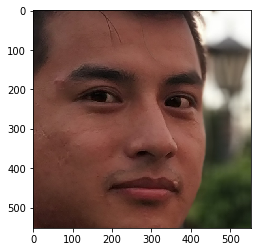

In [62]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(original_images[7])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

x = faces[0][0]
y = faces[0][1]
w = faces[0][2]
h = faces[0][3]

# Crop face from the image
cropped_face = img[y:y+h, x:x+w]

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# Convert from BGR to RGB color channel
cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cropped_face)
plt.show()

## Helper functions to extract cropped images 

In [ ]:
# Function to detect faces
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return (img, faces, len(faces) > 0)

def extract_dimensions(face):
    x = face[0][0]
    y = face[0][1]
    w = face[0][2]
    h = face[0][3]
    return (x, y, w, h)

def extract_faces(original_images, out_path):
    i = 0
    for image in original_images:
        i += 1
        img, faces, detected = face_detector(image)
        if detected:
            x, y, w, h = extract_dimensions(faces)
            face = img[y:y+h, x:x+h]
            print('Saving image ' + str(i) +'...')
            cv2.imwrite(out_path +'-'+str(i)+'.jpg', face)
    

In [ ]:
# Extract faces
# extract_faces(original_images, 'data/binuka/binuka')

In [ ]:
# wang valid images
# wang_valid = np.array(glob("images/wang-valid/*"))

In [ ]:
# Extract to data/valid/wang
# extract_faces(wang_valid, 'data/valid/wang/wang')

In [ ]:

# pema_train = np.array(glob("images/pema-train/*")) 
# pema_valid = np.array(glob("images/pema-valid/*"))
# pema_extra = np.array(glob("images/pema_extra/*"))
# len(pema_extra)

In [ ]:
# Extract pema's training images and validation images
# extract_faces(pema_train, 'data/train/pema/pema')
# extract_faces(pema_extra, 'data/train/pema')

# Loading Data

In [28]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms

In [29]:
data_dir = 'data'

# Define data directories
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

image_transforms = {
    'train':
    transforms.Compose([transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
                       ]),
    'valid':
    transforms.Compose([transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
                       ])
}

# Loading datasets
train_data = datasets.ImageFolder(train_dir, transform=image_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=image_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform=image_transforms['valid'])

batch_size = 8

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(valid_data), len(test_data))

203 52 51


In [30]:
from torchvision import models
import numpy as np

In [31]:
# Load pretrained model
model_transfer = models.resnet50(pretrained=True)

In [34]:
model_transfer.fc 

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=128, out_features=2, bias=True)
  (7): LogSoftmax()
)

# Tuning Model

In [33]:
# Freeze the weights
for param in model_transfer.parameters():
  param.requires_grad = False

n_inputs = model_transfer.fc.in_features
n_classes = 2

model_transfer.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(128, 2),
                      nn.LogSoftmax(dim=1)
                      )
print(model_transfer)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:
# Freeze the weights
# for param in model_transfer.parameters():
#   param.requires_grad = False

# n_inputs = model_transfer.classifier[6].in_features
# n_classes = 2

# model_transfer.classifier[6] = nn.Sequential(
#                       nn.Linear(n_inputs, 256),
#                       nn.ReLU(),
#                       nn.Dropout(0.25),
#                       nn.Linear(256, 128),
#                       nn.ReLU(),
#                       nn.Dropout(0.25),
#                       nn.Linear(128, 2),
#                       nn.LogSoftmax(dim=1)
#                       )
# print(model_transfer)

# use_cuda = torch.cuda.is_available()

# if use_cuda:
#     model_transfer = model_transfer.cuda()

In [35]:
from torch import optim
criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters())

# Training Model

In [36]:
# train the model
from tqdm.notebook import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, checkpoint):
  # Early stopping details
  n_epochs_stop = 5
  min_val_loss = np.Inf
  epochs_no_improve = 0

  # Main Loop 
  for e in range(n_epochs):
    # Initialize validation loss for epoch
    val_loss = 0

    # Training Loop
    model_transfer.train()
    for images, labels in tqdm(loaders['train']):
      if use_cuda:
        images, labels = images.cuda(), labels.cuda()
      else:
        print("Working without gpu")

      # Clear previous accumulated gradients
      optimizer_transfer.zero_grad()

      # Generate prediction
      output = model_transfer(images)

      # Calculate loss
      loss = criterion_transfer(output, labels)

      # Backpropagation
      loss.backward()

      # Update model parameters
      optimizer_transfer.step()
    
    print("Calculating Validation loss...\n")

    # Validation Loop
    model_transfer.eval()
    for images, labels in loaders['valid']:
      if use_cuda:
        images, labels = images.cuda(), labels.cuda()

      # Generate predictions
      output = model_transfer(images)

      # Calculate loss
      loss = criterion_transfer(output, labels)

      val_loss += loss

    # Average validation loss
    val_loss = val_loss / len(train_loader)
    print("epoch {}/{}, Validation loss : {}".format(e+1, n_epochs, val_loss))

    if val_loss < min_val_loss:
      print("Validation loss decreased :{} --> {}\n".format(min_val_loss, val_loss))
      # Save the model
      torch.save(model_transfer.state_dict(), checkpoint)
      epochs_no_improve = 0
      min_val_loss = val_loss

    else:
      epochs_no_improve += 1

      # Check early stopping condition
      if epochs_no_improve == n_epochs_stop:
        print("Early Stopping!")

        # load in the best model
        model_transfer.load_state_dict(torch.load(checkpoint))
        break
  return model_transfer

loaders_transfer = {'train': train_loader,
                    'valid': valid_loader,
                    'test': test_loader}

save_as = 'models/model_transfer-1.pt'

model_transfer =  train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, save_as)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('models/model_transfer-1.pt'))


Calculating Validation loss...

epoch 1/30, Validation loss : 0.16030298173427582
Validation loss decreased :inf --> 0.16030298173427582




Calculating Validation loss...

epoch 2/30, Validation loss : 0.12840469181537628
Validation loss decreased :0.16030298173427582 --> 0.12840469181537628




Calculating Validation loss...

epoch 3/30, Validation loss : 0.21597380936145782



Calculating Validation loss...

epoch 4/30, Validation loss : 0.07605703920125961
Validation loss decreased :0.12840469181537628 --> 0.07605703920125961




Calculating Validation loss...

epoch 5/30, Validation loss : 0.10746913403272629



Calculating Validation loss...

epoch 6/30, Validation loss : 0.044369086623191833
Validation loss decreased :0.07605703920125961 --> 0.044369086623191833




Calculating Validation loss...

epoch 7/30, Validation loss : 0.040760427713394165
Validation loss decreased :0.044369086623191833 --> 0.040760427713394165




Calculating Validation loss...

epoch 8/30, Validation loss : 0.05886535346508026



Calculating Validation loss...

epoch 9/30, Validation loss : 0.03816434368491173
Validation loss decreased :0.040760427713394165 --> 0.03816434368491173




Calculating Validation loss...

epoch 10/30, Validation loss : 0.036431293934583664
Validation loss decreased :0.03816434368491173 --> 0.036431293934583664




Calculating Validation loss...

epoch 11/30, Validation loss : 0.07061028480529785



Calculating Validation loss...

epoch 12/30, Validation loss : 0.039294298738241196



Calculating Validation loss...

epoch 13/30, Validation loss : 0.05698621645569801



Calculating Validation loss...

epoch 14/30, Validation loss : 0.049550801515579224



Calculating Validation loss...

epoch 15/30, Validation loss : 0.0350436195731163
Validation loss decreased :0.036431293934583664 --> 0.0350436195731163




Calculating Validation loss...

epoch 16/30, Validation loss : 0.04642883688211441



Calculating Validation loss...

epoch 17/30, Validation loss : 0.03446805477142334
Validation loss decreased :0.0350436195731163 --> 0.03446805477142334




Calculating Validation loss...

epoch 18/30, Validation loss : 0.2312593162059784



Calculating Validation loss...

epoch 19/30, Validation loss : 0.06600211560726166



Calculating Validation loss...

epoch 20/30, Validation loss : 0.1416155993938446



Calculating Validation loss...

epoch 21/30, Validation loss : 0.035492122173309326



Calculating Validation loss...

epoch 22/30, Validation loss : 0.03914579376578331
Early Stopping!


<All keys matched successfully>

In [ ]:
del model_transfer
torch.cuda.empty_cache()

# Testing Model Accuracy on unseen data

In [37]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in tqdm(enumerate(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

# test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


Test Loss: 0.128460


Test Accuracy: 94% (48/51)


In [38]:
extra = np.array(glob("images/extra/*"))

In [39]:
len(extra)

15

In [40]:
extra[0]

'images/extra\\wang-109.jpg'

# Function to test other images

In [80]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def who_is_in_the_pic(img_path):

    input_img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(input_img)
    input_batch = input_tensor.unsqueeze(0)

    # Move the input to gpu if available
    if use_cuda:
      input_batch = input_batch.cuda()

    with torch.no_grad():
      output = model_transfer(input_batch)

    prob, index = torch.max(F.softmax(output[0]), 0)
    
    return prob, index # predicted class index

In [42]:
train_data.class_to_idx

{'pema': 0, 'wang': 1}

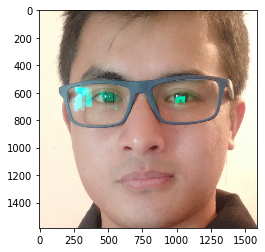

In [75]:
import matplotlib.pyplot as plt 
from PIL import Image

img = Image.open(extra[0])
plt.imshow(img)


In [84]:
probability, index = who_is_in_the_pic(extra[7])
if index == 1:
    print("It's wang in the picture\nProbability of being wang: {:.2f}".format(probability))
else:
    print("It's pema in the picture")

It's wang in the picture
Probability of being wang: 1.00


C:\Users\Asus\anaconda\envs\face_recognition\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
